Добейтесь средней точности 91-92% в задаче поиска мошеннических операций. Для этого попробуйте сделать более мощный автокодировщик и гибкую настройку порога (bias), по которому мы определяем, мошенническая транзакция или нет

Постройте на одном графике 2 гистограммы (density=True) для нормальных и мошеннических транзакций. По графику определите 3 порога:
1) при котором все мошеннические транзакции будут пойманы
2) “оптимальный порог” - на пересечении распределений
3) при котором ни одна нормальная транзакция не будет распознана, как мошенническая

In [ ]:
from tensorflow.keras.models import Model, Sequential # загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
# Из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Dropout
from tensorflow.keras import backend as K # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор
from tensorflow.keras import utils # загружаем утилиты кераса
from tensorflow.keras.datasets import mnist, fashion_mnist # загружаем готовые базы mnist
from tensorflow.keras.callbacks import LambdaCallback

import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
import numpy as np # библиотека для работы с массивами данных
import pandas as pd # библиотека для анализа и обработки данных
from PIL import Image # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split # модуль для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler # модуль для стандартизации данных

import os #
from google.colab import drive #модуль для работы с google диском 
import time, random
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
drive.mount('/content/drive/') # монтируем google диск

Mounted at /content/drive/


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Lessons/Lesson9/creditcard.csv") # читаем базу

In [ ]:
df.head() # выводим первые пять строк

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Удаляем столбец со временем
data = df.drop(['Time'], axis=1)
# Нормализуем столбец с суммой транзакции
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

frauds = data[data.Class == 1] # записываем мошеннические операции
normal = data[data.Class == 0] # записываем нормальные операции

In [ ]:
frauds.shape # смотрим какие размеры у мошеннических операций

(492, 30)

In [ ]:
normal.shape # смотрим какие размеры у нормальных операций

(284315, 30)

In [ ]:
RANDOM_SEED = 42 # задаем случайное значение
# берём нормальные операции и разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# Удаляем класс в обучающем наборе данных
X_train = X_train.drop(['Class'], axis=1)
# Добавляем все мошеннические транзакции в тестовый набор данных
X_test = pd.concat([X_test, frauds])
# Делаем метки для тестового набора данных
y_test = X_test['Class']
# Удаляем класс у тестового набора данных
X_test = X_test.drop(['Class'], axis=1)
# Преобразуем данные в массивы numpy
X_train = X_train.values
X_test = X_test.values

In [ ]:
print(X_train.shape) # взглянем на размеры обучающих данных

(227452, 29)


In [ ]:
def creditcardAutoencoder(): # объявляем автокодировщик для определения мошенич.транзакций
  dataSize = X_train.shape[1] # берём размеры X_train по второй оси(30)
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(10, activation='relu')(dataInput)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(100, activation='relu')(x) # пропускаем через полносвязный слой размером 10
  x = Dense(dataSize, activation='linear')(x) # и через полносвязный слой размером 29 
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer='Adam', loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
model = creditcardAutoencoder()

In [ ]:
history = model.fit(X_train, X_train,
                    epochs=50,
                    batch_size=32) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/50
7108/7108 [==============================] - 15s 2ms/step - loss: 0.2493
Epoch 2/50
7108/7108 [==============================] - 15s 2ms/step - loss: 0.1408
Epoch 3/50
7108/7108 [==============================] - 14s 2ms/step - loss: 0.1243
Epoch 4/50
7108/7108 [==============================] - 15s 2ms/step - loss: 0.1167
Epoch 5/50
7108/7108 [==============================] - 15s 2ms/step - loss: 0.1116
Epoch 6/50
7108/7108 [==============================] - 15s 2ms/step - loss: 0.1067
Epoch 7/50
7108/7108 [==============================] - 14s 2ms/step - loss: 0.1031
Epoch 8/50
7108/7108 [==============================] - 15s 2ms/step - loss: 0.1000
Epoch 9/50
7108/7108 [==============================] - 15s 2ms/step - loss: 0.0967
Epoch 10/50
7108/7108 [==============================] - 14s 2ms/step - loss: 0.0951
Epoch 11/50
7108/7108 [==============================] - 14s 2ms/step - loss: 0.0916
Epoch 12/50
7108/7108 [==============================] - 17s 2ms/step - lo

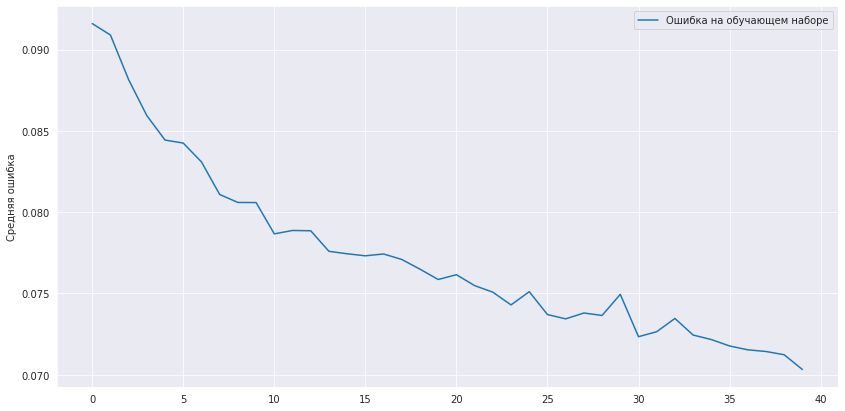

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Ошибка на обучающем наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test) # делаем предсказание по X_test

In [ ]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1) # определяем среднеквадратичную ошибку по X_test и предсказанием по X_test

In [ ]:
mse_normal = mse[y_test.values == 0] # среднеквадратичная ошибка на нормальных операциях
mse_frauds = mse[y_test.values == 1] # среднеквадратичная ошибка на мошеннических операциях

In [ ]:
print("Минимальная ошибка нормальных транзакций:", round(min(mse_normal),4)) #найдем минимальную среднеквадратичную ошибку на нормальных операциях
print("Максимальная ошибка нормальных транзакций:", round(max(mse_normal),4)) #найдем максимальную среднеквадратичную ошибку на нормальных операциях
print("Средняя ошибка нормальных транзакций:", round(sum(mse_normal) / len(mse_normal),4)) # среднюю ошибку

Минимальная ошибка нормальных транзакций: 0.0042
Максимальная ошибка нормальных транзакций: 73.5338
Средняя ошибка нормальных транзакций: 0.0705


In [ ]:
print("Минимальная ошибка мошеннических транзакций:", round(min(mse_frauds),4)) #найдем минимальную среднеквадратичную ошибку на мошеннических операциях
print("Максимальная ошибка мошеннических транзакций:", round(max(mse_frauds),4)) #найдем максимальную среднеквадратичную ошибку на мошеннических операциях
print("Средняя ошибка мошеннических транзакций:", round(sum(mse_frauds) / len(mse_frauds),4)) # среднюю ошибку

Минимальная ошибка мошеннических транзакций: 0.0098
Максимальная ошибка мошеннических транзакций: 76.465
Средняя ошибка мошеннических транзакций: 4.643


In [ ]:
def getAccByBias(bias, write=True): # функция будет принимать какое то пороговое значение
  isNormal = mse_normal < bias # если ошибка меньше порога - то транзакция нормальная
  isFrauds = mse_frauds > bias # если ошибка больше порога - то транзакция мошенническая

  accNormal = sum(isNormal) / len(isNormal) # вычисляем процент нормальных операций
  accFaruds = sum(isFrauds) / len(isFrauds) # вычисляем процент мошеннических операций
  if write:
    print("Распознано нормальных транзакций: ", round(100*accNormal), "%", sep="")
    print("Распознано мошеннических транзакций: ", round(100*accFaruds), "%", sep="")
    print("Средняя точность распознавания: ", round(50*(accNormal + accFaruds)), "%", sep="")
  return [accNormal, accFaruds, 50*(accNormal + accFaruds)]

In [ ]:
getAccByBias(0.35) # выведем данные по распознаванию с конкретным пороговым значением

Распознано нормальных транзакций: 98%
Распознано мошеннических транзакций: 84%
Средняя точность распознавания: 91%


[0.9770676890069113, 0.8394308943089431, 90.82492916579272]

In [ ]:
x = [ii*1e-1 for ii in range(10)]
y = [getAccByBias(ii, False) for ii in x]
accNorm = [elem[0] for elem in y]
accFar = [elem[1] for elem in y]



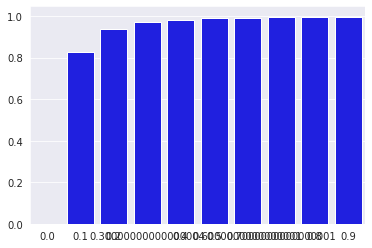

In [ ]:
sns.barplot(x=x, y=accNorm, color='blue');


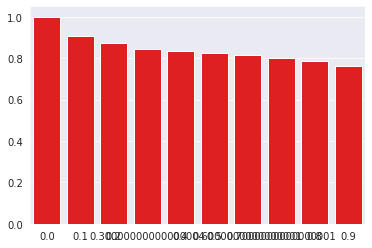

In [ ]:
sns.barplot(x=x, y=accFar, color="red")

# Вывод

## 1 порог

При значении bias 0.0 все мошеннические транзакции будут пойманы

## 2 порог

“Оптимальный порог” - 0.35

## 3 порог

При значении bias 0.5 ни одна нормальная транзакция не будет распознана, как мошенническая